In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
import torch_directml

device = torch_directml.device()

# Обработка и загрузка данных

In [4]:
import os
import shutil
from PIL import Image
from tqdm import tqdm

RANDOM_STATE = 0
TEST_SIZE = 0.5


class BWHDataset(Dataset):
    SPLIT_RANDOM_SEED = RANDOM_STATE
    SPLIT_TEST_SIZE = TEST_SIZE

    def __init__(self, folder, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.folder = folder
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.filenames = os.listdir(self.folder)
        self.train_val_labels = pd.read_csv('bhw1-dataset/labels.csv')
        train_files, val_files = train_test_split(self.filenames, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        if train:
            self.all_files += train_files
            self.all_labels += list(self.train_val_labels.loc[self.train_val_labels['Id'].isin(train_files), 'Label'].values)
            if load_to_ram:
                self.images += self._load_images(train_files)
        else:
            self.all_files += val_files
            self.all_labels += list(self.train_val_labels.loc[self.train_val_labels['Id'].isin(val_files), 'Label'].values)
            if load_to_ram:
                self.images += self._load_images(val_files)


    def _load_images(self, files):
        images = []
        for filename in tqdm(files, 'Dataset loading'):
            image = Image.open(os.path.join(self.folder, filename)).convert('RGB')
            images += [image]
        return images
    

    def __len__(self):
        return len(self.all_files)
    

    def __getitem__(self, index):
        label = self.all_labels[index]
        if self.load_to_ram:
            image = self.images[index]
        else:
            filename = self.all_files[index]
            image = Image.open(os.path.join(self.folder, filename))

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [5]:
train_val_folder = 'bhw1-dataset/trainval/'
train_dataset = BWHDataset(folder=train_val_folder, train=True, load_to_ram=False)

In [6]:
temp_image, temp_label = train_dataset[100]
temp_label, temp_image.size

(177, (64, 64))

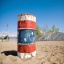

In [7]:
temp_image

In [8]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])

In [9]:
train_dataset = BWHDataset(folder=train_val_folder, train=True, load_to_ram=True, transform=test_transform)
test_dataset = BWHDataset(folder=train_val_folder, train=False, load_to_ram=True, transform=test_transform)

Dataset loading: 100%|██████████| 50000/50000 [10:56<00:00, 76.17it/s] 


# Обучение модели

In [161]:
def train_epoch(model, optimizer, criterion, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 

    return loss_log, acc_log


# @torch.inference_mode()
def test(model, criterion, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in tqdm(loader, 'Test batch'):     
        data = data.to(device)
        target = torch.from_numpy(target.reshape(1, -1)[0]).to(device)
        with torch.no_grad():
            logits = model(data.unsqueeze(0))
            loss = criterion(logits, target)
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum()  / data.shape[0]
        acc_log.append(acc.item()) 
    
    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, criterion, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader, 'Train batch'):
        data = data.to(device)
        target = torch.from_numpy(target.reshape(1, -1)[0]).to(device)
        optimizer.zero_grad()
        logits = model(data.unsqueeze(0))
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, criterion, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader)
        val_loss, val_acc = test(model, criterion, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss):.5f}, train acc: {np.mean(train_acc):.5f}")
        print(f" val loss: {val_loss:.5f}, val acc: {val_acc:.5f}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [11]:
from torchvision.models import mobilenet_v3_small

num_epochs = 20
n_classes = train_dataset.train_val_labels['Label'].unique().size
model = mobilenet_v3_small(num_classes=n_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [12]:
# one epoch ~100 min :(
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, criterion, num_epochs, train_dataset, test_dataset, scheduler)

Epoch 0
 train loss: 5.33216, train acc: 0.00163
 val loss: 5.70516, val acc: 0.00176

Epoch 1
 train loss: 5.32890, train acc: 0.00173
 val loss: 6.05525, val acc: 0.00165



KeyboardInterrupt: 

# Fine-tuning

In [14]:
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights).to(device)

C:\Users\dimaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\dimaz/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [15]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [18]:
model.classifier[3] = torch.nn.Linear(1024, n_classes)
model = model.to(device)

In [149]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [151]:
# my pc is too weak, i'm sorry :(
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, criterion, num_epochs, train_dataset, test_dataset, scheduler)

# Сокращение датасета

In [93]:
# choice_param = 0.3
# grouped_labels = train_val_labels.groupby('Label')['Id'].apply(np.array)
# cut_labels = grouped_labels.apply(lambda x: np.random.choice(x, size=np.floor(x.size * choice_param).astype(int)))
# splitted_labels = cut_labels.apply(lambda x: train_test_split(x, test_size=TEST_SIZE))
# train_data, val_data = [], []
# for label_data in splitted_labels:
#     train_data.extend(label_data[0])
#     val_data.extend(label_data[1])

In [139]:
import os
from PIL import Image
from tqdm import tqdm

RANDOM_STATE = 0
TEST_SIZE = 0.3
np.random.seed(RANDOM_STATE)


# fixed dataset loader
class BWHDataset(Dataset):
    SPLIT_RANDOM_SEED = RANDOM_STATE
    SPLIT_TEST_SIZE = TEST_SIZE

    def __init__(self, folder='bhw1-dataset/trainval/', choice_param=None, n_classes=None, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.folder = folder
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []
        self.choice_param = choice_param
        self.n_classes = n_classes

        self.filenames = os.listdir(self.folder)
        self.train_val_labels = pd.read_csv('bhw1-dataset/labels.csv')        
        self.grouped_labels = self.train_val_labels.groupby('Label')['Id'].apply(np.array)
        if self.n_classes is not None:
            self.grouped_labels = self.grouped_labels[:self.n_classes]
        if self.choice_param is not None:
            self.grouped_labels = self.grouped_labels.apply(
                lambda x: np.random.choice(x, size=np.floor(x.size * self.choice_param).astype(int))
            )
        splitted_labels = self.grouped_labels.apply(lambda x: train_test_split(x, test_size=TEST_SIZE, random_state=RANDOM_STATE))
        train_files, val_files = [], []
        for label_data in splitted_labels:
            train_files.extend(label_data[0])
            val_files.extend(label_data[1])
        if train:
            self.all_files += train_files
            self.all_labels += list(self.train_val_labels.loc[self.train_val_labels['Id'].isin(train_files), 'Label'].values)
            if load_to_ram:
                self.images += self._load_images(train_files)
        else:
            self.all_files += val_files
            self.all_labels += list(self.train_val_labels.loc[self.train_val_labels['Id'].isin(val_files), 'Label'].values)
            if load_to_ram:
                self.images += self._load_images(val_files)
        
                

    def _load_images(self, files):
        images = []
        for filename in tqdm(files, 'Dataset loading'):
            image = Image.open(os.path.join(self.folder, filename)).convert('RGB')
            images += [image]
        return images
    

    def __len__(self):
        return len(self.all_files)
    

    def __getitem__(self, index):
        filename = self.all_files[index]
        label = self.train_val_labels[self.train_val_labels['Id']==filename]['Label'].values[0]
        if self.load_to_ram:
            image = self.images[index]
        else:
            image = Image.open(os.path.join(self.folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [140]:
n_classes = 10
train_dataset = BWHDataset(folder=train_val_folder, choice_param=0.1, n_classes=n_classes, train=True, load_to_ram=True, transform=test_transform)
test_dataset = BWHDataset(folder=train_val_folder, choice_param=0.1, n_classes=n_classes, train=False, load_to_ram=True, transform=test_transform)

Dataset loading: 100%|██████████| 150/150 [00:01<00:00, 79.77it/s]


### Проверка корректности датасета

In [141]:
train_dataset[100][1]

2

In [142]:
train_dataset.all_files[100]

'trainval_76106.jpg'

In [143]:
df_temp = train_dataset.train_val_labels
df_temp[df_temp['Id']==train_dataset.all_files[100]]['Label']

76106    2
Name: Label, dtype: int64

In [152]:
test_dataset[100][1], test_dataset.all_files[100]

(6, 'trainval_77878.jpg')

In [153]:
df_temp = test_dataset.train_val_labels
df_temp[df_temp['Id']==test_dataset.all_files[100]]['Label']

77878    6
Name: Label, dtype: int64

## Обучение модели

In [164]:
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)

In [165]:
model.classifier[3] = torch.nn.Linear(1024, n_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [166]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, criterion, num_epochs, train_dataset, test_dataset, scheduler)

Test batch: 100%|██████████| 150/150 [00:03<00:00, 42.56it/s]


Epoch 0
 train loss: 3.38053, train acc: 0.30286
 val loss: 15.67615, val acc: 0.02889



Test batch: 100%|██████████| 150/150 [00:04<00:00, 36.86it/s]


Epoch 1
 train loss: 4.23934, train acc: 0.30381
 val loss: 343.20961, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:07<00:00, 21.00it/s]


Epoch 2
 train loss: 4.34544, train acc: 0.29524
 val loss: 629.28765, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:09<00:00, 15.23it/s]


Epoch 3
 train loss: 5.76101, train acc: 0.28857
 val loss: 22.39320, val acc: 0.03556



Test batch: 100%|██████████| 150/150 [00:09<00:00, 15.35it/s]


Epoch 4
 train loss: 2.76583, train acc: 0.29238
 val loss: 504.64850, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:09<00:00, 15.89it/s]


Epoch 5
 train loss: 2.97904, train acc: 0.28952
 val loss: 260.12550, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:03<00:00, 39.84it/s]


Epoch 6
 train loss: 1.92575, train acc: 0.29048
 val loss: 569.96495, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:09<00:00, 15.82it/s]


Epoch 7
 train loss: 2.09853, train acc: 0.27810
 val loss: 514.20815, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:03<00:00, 40.25it/s]


Epoch 8
 train loss: 1.50990, train acc: 0.26286
 val loss: 570.03051, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:05<00:00, 27.06it/s]


Epoch 9
 train loss: 1.82238, train acc: 0.23619
 val loss: 580.20277, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:03<00:00, 40.27it/s]


Epoch 10
 train loss: 1.87407, train acc: 0.22952
 val loss: 496.84301, val acc: 0.02667



Test batch: 100%|██████████| 150/150 [00:12<00:00, 12.36it/s]


Epoch 11
 train loss: 1.78497, train acc: 0.19238
 val loss: 532.07928, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:09<00:00, 16.61it/s]


Epoch 12
 train loss: 2.10213, train acc: 0.13429
 val loss: 491.34201, val acc: 0.03111



Test batch: 100%|██████████| 150/150 [00:04<00:00, 31.57it/s]


Epoch 13
 train loss: 1.85107, train acc: 0.16952
 val loss: 518.02770, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epoch 14
 train loss: 2.28086, train acc: 0.06381
 val loss: 531.56555, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:04<00:00, 32.63it/s]


Epoch 15
 train loss: 2.67330, train acc: 0.00476
 val loss: 530.59560, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:04<00:00, 36.32it/s]


Epoch 16
 train loss: 2.48849, train acc: 0.00571
 val loss: 530.97504, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:04<00:00, 32.86it/s]


Epoch 17
 train loss: 2.43242, train acc: 0.02095
 val loss: 531.20252, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:03<00:00, 38.47it/s]


Epoch 18
 train loss: 2.36846, train acc: 0.02000
 val loss: 531.44133, val acc: 0.03333



Test batch: 100%|██████████| 150/150 [00:04<00:00, 32.32it/s]

Epoch 19
 train loss: 2.34448, train acc: 0.02095
 val loss: 531.39281, val acc: 0.03333



## Сокращение датасета V2

In [167]:
n_classes = 5
train_dataset = BWHDataset(folder=train_val_folder, n_classes=n_classes, train=True, load_to_ram=True, transform=train_transform)
test_dataset = BWHDataset(folder=train_val_folder, n_classes=n_classes, train=False, load_to_ram=True, transform=test_transform)

Dataset loading: 100%|██████████| 750/750 [00:09<00:00, 75.52it/s] 


In [168]:
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
model.classifier[3] = torch.nn.Linear(1024, n_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [169]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, criterion, num_epochs, train_dataset, test_dataset, scheduler)

Test batch: 100%|██████████| 750/750 [00:18<00:00, 40.36it/s]


Epoch 0
 train loss: 0.18271, train acc: 0.33105
 val loss: 11.02816, val acc: 0.07378



Test batch: 100%|██████████| 750/750 [00:32<00:00, 22.97it/s]


Epoch 1
 train loss: 0.46256, train acc: 0.33067
 val loss: 116.51251, val acc: 0.06667



Test batch: 100%|██████████| 750/750 [00:25<00:00, 29.45it/s]


Epoch 2
 train loss: 0.49168, train acc: 0.33086
 val loss: 722.96066, val acc: 0.06667



Test batch: 100%|██████████| 750/750 [00:19<00:00, 38.79it/s]


Epoch 3
 train loss: 0.47645, train acc: 0.33067
 val loss: 340.16152, val acc: 0.06622



Train batch:   4%|▎         | 65/1750 [00:06<02:53,  9.73it/s]


KeyboardInterrupt: 

# Custom RESNet

In [176]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [179]:
class BasicBlockNet(nn.Module):
    def __init__(self, image_channels=3, out_channels=64):
        super().__init__()
        self.conv1 = nn.Conv2d(  # 3 x 64 x 64
            in_channels=image_channels, out_channels=out_channels, kernel_size=1
        ) # 64 x 64 x 64
        self.basic_block = nn.Sequential( # 3 x 64 x 64
            nn.Conv2d(in_channels=image_channels, out_channels=out_channels, kernel_size=3, padding=1), # 64 x 64 x 64
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1), # 64 x 64 x 64
            nn.BatchNorm2d(num_features=out_channels) 
        ) # 64 x 64 x 64
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=5,stride=7) 
        self.linear = nn.Linear(in_features=64 * 9 * 9, out_features=n_classes)

    def forward(self, x):
        residual = self.conv1(x) # 64 x 64 x 64
        basic_out = self.basic_block(x) # 64 x 64 x 64
        pooled_out = self.avgpool(self.relu(basic_out + residual)) # 64 x 4 x 4
        out = self.linear(pooled_out.flatten(start_dim=1)) # 64 * 9 * 9
        return out

In [183]:
net = BasicBlockNet()
model = net.to(device)

In [184]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [185]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, criterion, num_epochs, train_dataset, test_dataset, scheduler)

Test batch: 100%|██████████| 750/750 [00:10<00:00, 68.53it/s]


Epoch 0
 train loss: 0.71046, train acc: 0.32800
 val loss: 7.13116, val acc: 0.06667



Test batch: 100%|██████████| 750/750 [00:14<00:00, 52.72it/s]


Epoch 1
 train loss: 0.32859, train acc: 0.31486
 val loss: 4.22846, val acc: 0.06667



Test batch: 100%|██████████| 750/750 [00:22<00:00, 33.84it/s]


Epoch 2
 train loss: 0.73043, train acc: 0.31429
 val loss: 4.18234, val acc: 0.06667



Test batch: 100%|██████████| 750/750 [00:16<00:00, 45.17it/s]


Epoch 3
 train loss: 0.47531, train acc: 0.30819
 val loss: 119.60040, val acc: 0.06667



Train batch:   9%|▉         | 160/1750 [00:10<01:43, 15.36it/s]


KeyboardInterrupt: 